In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanorama
import scanpy as sc
import random
import seaborn as sns

import scipy.spatial

import networkx as nx
import itertools


np.random.seed(0)
random.seed(0)

In [39]:
import sys
sys.path.append("../../..")
from decipher.load_data import palette_original
palette_original["normal"] = palette_original["Healthy"]
palette_original["perturbed"] = palette_original["AML1"]


In [9]:
sc.settings.set_figure_params(dpi_save=1200, vector_friendly=True, fontsize=18)
plt.rcParams['axes.grid'] = False

In [6]:
def load_data(path, ref=None):
    adata = sc.read_h5ad(path)
    adata.obs["origin"].replace(
        {
            "p89": "perturbed",
            "AML1": "perturbed",
            "healthy": "normal",
            "Healthy": "normal",
        },
        inplace=True,
    )
    if ref is None:
        adata.obs["cd34+"] = (adata[:, "CD34"].X >= 5).toarray().astype(float)
    else:
        adata.obs["cd34+"] = ref.obs["cd34+"][adata.obs.index]
    return adata

ref_adata = load_data("outputs-achille/umap-tsne.h5ad")

In [7]:
def compute_location_score(adata, obsm_key, mode=0, get_distances=False):
    adata.obs["CD34+"] = adata[:, "CD34"].X.toarray()[:, 0] > 2
    adata.obs["MPO+"] = adata[:, "MPO"].X.toarray()[:, 0] > 2
    #     adata.obs["NPM1+"] = (adata[:, "NPM1"].X.toarray()[:, 0] > 50).astype(int)
    adata.obs["IGLL1+"] = adata[:, "IGLL1"].X.toarray()[:, 0] > 50

    normal = adata[adata.obs["origin"] == "normal"]
    normal_immature = normal[normal.obs["cell_type_merged"] == "immature"]
    normal_stage1 = normal_immature[normal_immature.obs["CD34+"]]
    normal_stage2 = normal_immature[normal_immature.obs["IGLL1+"]]
    normal_stage3 = normal_immature[normal_immature.obs["MPO+"]]

    perturbed = adata[adata.obs["origin"] == "perturbed"]
    perturbed_immature = perturbed[perturbed.obs["cell_type_merged"] == "immature"]
    perturbed_blast0 = perturbed[perturbed.obs["cell_type_merged"] == "blast0"]
    perturbed_blast1 = perturbed[perturbed.obs["cell_type_merged"] == "blast1"]
    perturbed_blast2 = perturbed[perturbed.obs["cell_type_merged"] == "blast2"]
    perturbed_blast3 = perturbed[perturbed.obs["cell_type_merged"] == "blast3"]

    G = nx.Graph()
    G.add_nodes_from(
        [
            ("normal_stage1", {"adata": normal_stage1}),
            ("normal_stage2", {"adata": normal_stage2}),
            ("normal_stage3", {"adata": normal_stage3}),
            ("perturbed_immature", {"adata": perturbed_immature}),
            ("perturbed_blast0", {"adata": perturbed_blast0}),
            ("perturbed_blast1", {"adata": perturbed_blast1}),
            ("perturbed_blast2", {"adata": perturbed_blast2}),
            ("perturbed_blast3", {"adata": perturbed_blast3}),
        ]
    )
    G.add_edges_from(
        [
            ("normal_stage1", "normal_stage2"),
            ("normal_stage2", "normal_stage3"),
            ("normal_stage1", "perturbed_immature"),
            ("perturbed_immature", "perturbed_blast0"),
            ("perturbed_blast0", "perturbed_blast1"),
            ("perturbed_blast1", "perturbed_blast2"),
            ("perturbed_blast2", "perturbed_blast3"),
        ]
    )
    score = 0

    sampled_distances = scipy.spatial.distance.cdist(
        sc.pp.subsample(adata, n_obs=2000, copy=True).obsm[obsm_key],
        sc.pp.subsample(adata, n_obs=2000, copy=True).obsm[obsm_key],
    )**2

    if mode == 0:
        intrinsic_distance = sampled_distances.mean()
    if mode == 1:
        intrinsic_distance = sampled_distances.max()
    if mode == 2:
        intrinsic_distance = np.quantile(sampled_distances.flatten(), 0.99)

    distances = []

    def weight(d):
        if d == 1:
            return 2
        if d == 2:
            return 0
        if 3 <= d:
            return -1
        return 0

    for n1, n2 in itertools.combinations(G.nodes, 2):
        distance = (scipy.spatial.distance.cdist(
            G.nodes[n1]["adata"].obsm[obsm_key],
            G.nodes[n2]["adata"].obsm[obsm_key],
        )**2).mean()
        distances.append([n1, n2, nx.shortest_path_length(G, n1, n2), distance])
        score = score + weight(nx.shortest_path_length(G, n1, n2)) * distance

    distances = pd.DataFrame(distances, columns=["n1", "n2", "d", "distance"])
    if mode == 3:
        intrinsic_distance = distances["distance"].mean()

    score /= intrinsic_distance
    distances["distance"] /= intrinsic_distance
    if get_distances:
        return distances
    return score

In [32]:
for m in [0]:
    scores = []

    for path, name, attr in [
        ("outputs/pca-umap-tsne.h5ad", "PCA", "X_pca"),
        ("outputs/pca-umap-tsne.h5ad", "TSNE", "X_tsne"),
        ("outputs/pca-umap-tsne.h5ad", "UMAP", "X_umap"),
        ("outputs/force_atlas2.h5ad", "FA", "X_draw_graph_fa"),
#         ("outputs-achille/scvi.h5ad", "scVI w. BC", "X_scVI"),
#         ("outputs-achille/scvi_no_effects.h5ad", "scVI wo. BC", "X_scVI_noeffects"),
#         ("outputs-achille/phate.h5ad", "Phate", "phate"),
#         ("outputs-achille/harmony.h5ad", "Harmony", "X_pca_harmony"),
#         ("outputs-achille/AML1.decipher.analyzed.h5ad", "Decipher v", "decipher_v"),
#         ("outputs-achille/AML1.decipher.analyzed.h5ad", "Decipher z", "decipher_z"),
        ("outputs/seurat.h5ad", "Seurat PCA", "X_pca"),
        ("outputs/seurat.h5ad", "Seurat UMAP", "X_umap"),
    ]:
        adata = load_data(path, ref_adata)
        score = compute_location_score(adata, attr, m)
        scores.append([name, -score])
    
    print(m)
    for n,s in sorted(scores, key=lambda x: x[1]):
        print(n,s)    
scores = pd.DataFrame(scores, columns=["Method", "Biological Fidelity"])

0
scVI w. BC 2.973069164461794
Harmony 3.2765254389175515
Seurat PCA 4.361100940320897
PCA 4.587966836488275
scVI wo. BC 5.560505048829691
Phate 6.249476956577951
Seurat UMAP 9.514143131348908
TSNE 9.939917792228325
UMAP 11.22005738759067
FA 13.401138050469559
Decipher z 13.80439395488025
Decipher v 17.862487034877425


In [10]:
for m in [0]:
    scores = []

    for path, name, attr in [
        ("outputs/pca-umap-tsne.h5ad", "PCA", "X_pca"),
        ("outputs/pca-umap-tsne.h5ad", "TSNE", "X_tsne"),
        ("outputs/pca-umap-tsne.h5ad", "UMAP", "X_umap"),
        ("outputs/force_atlas2.h5ad", "FA", "X_draw_graph_fa"),
        ("outputs-achille/scvi.h5ad", "scVI w. BC", "X_scVI"),
        ("outputs-achille/scvi_no_effects.h5ad", "scVI wo. BC", "X_scVI_noeffects"),
        ("outputs-achille/phate.h5ad", "Phate", "phate"),
        ("outputs-achille/harmony.h5ad", "Harmony", "X_pca_harmony"),
        ("outputs-achille/AML1.decipher.analyzed.h5ad", "Decipher v", "decipher_v"),
        ("outputs-achille/AML1.decipher.analyzed.h5ad", "Decipher z", "decipher_z"),
        ("outputs/seurat.h5ad", "Seurat PCA", "X_pca"),
        ("outputs/seurat.h5ad", "Seurat UMAP", "X_umap"),
    ]:
        adata = load_data(path, ref_adata)
        score = compute_location_score(adata, attr, m)
        scores.append([name, -score])
    
    print(m)
    for n,s in sorted(scores, key=lambda x: x[1]):
        print(n,s)    
scores = pd.DataFrame(scores, columns=["Method", "Biological Fidelity"])

0
scVI w. BC 2.973069164461794
Harmony 3.2765254389175515
Seurat PCA 4.391418175377332
PCA 4.587966836488275
scVI wo. BC 5.560505048829691
Phate 6.249476956577951
TSNE 9.939917792228325
Seurat UMAP 10.955809191681833
UMAP 11.22005738759067
FA 13.401138050469559
Decipher z 13.80439395488025
Decipher v 17.862487034877425


In [22]:
scores = scores.replace(
    {
        "scVI w. BC": "scVI\nw. BC",
        "scVI wo. BC": "scVI\nwo. BC",
        "Decipher v": "Decipher\nv",
        "Decipher z": "Decipher\nz",
        "Seurat PCA": "Seurat\nPCA",
        "Seurat UMAP": "Seurat\nUMAP",
    },
)

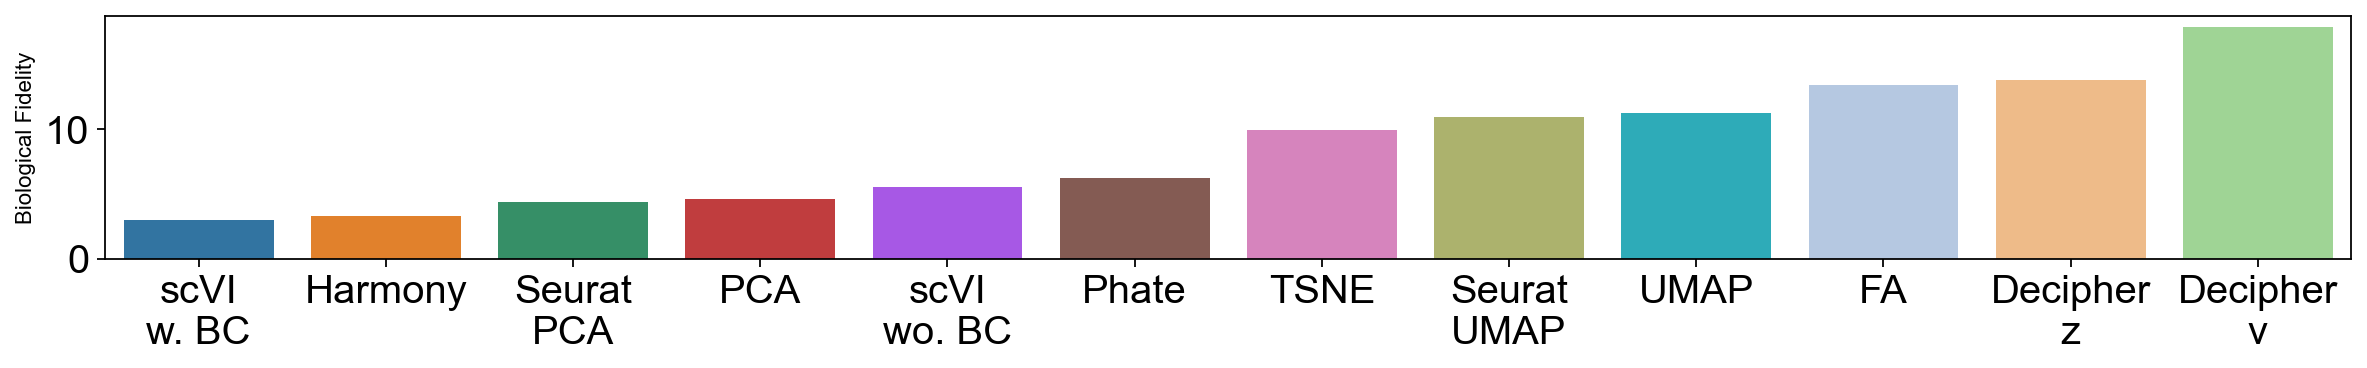

In [25]:
with plt.rc_context(
    {"axes.titlesize": 15, "axes.labelsize": 10, "figure.figsize": [18,2]}
):
    sns.barplot(
        data=scores.sort_values("Biological Fidelity", ascending=True),
        x="Method",
        y="Biological Fidelity",
    )
#     plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.xlabel(None)
plt.savefig("../figures/figure2/benchmark.biological_fidelity.pdf", bbox_inches="tight")


In [60]:
adata.obsm["X_pca_harmony"]

(18000, 50)

In [61]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)

In [62]:
sc.write("outputs-achille/harmony_with_umap.h5ad", adata)

/opt/miniconda3/envs/R/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/R/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/R/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/R/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/R/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  

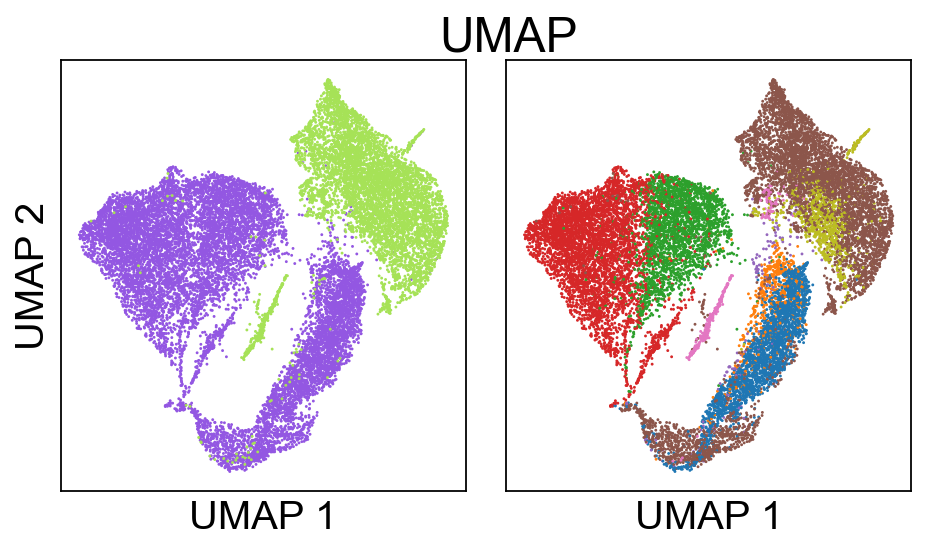

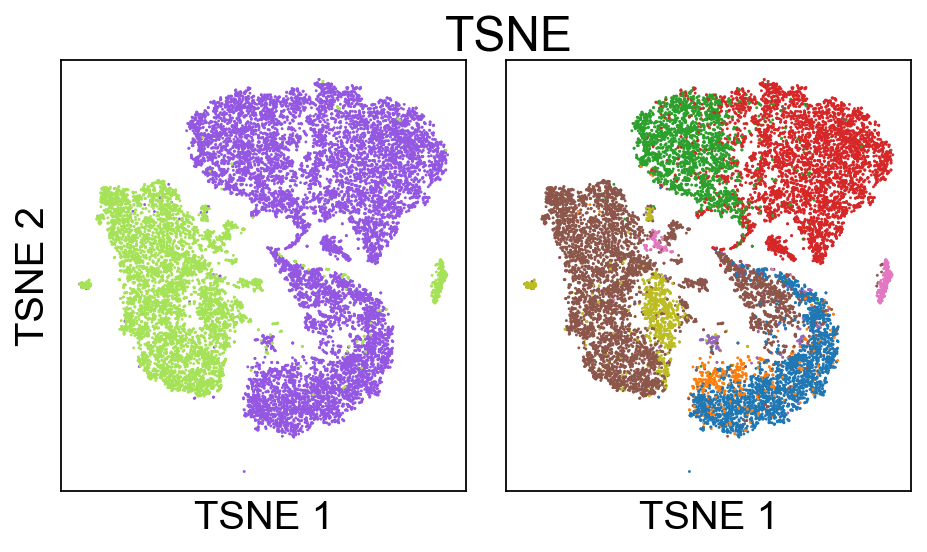

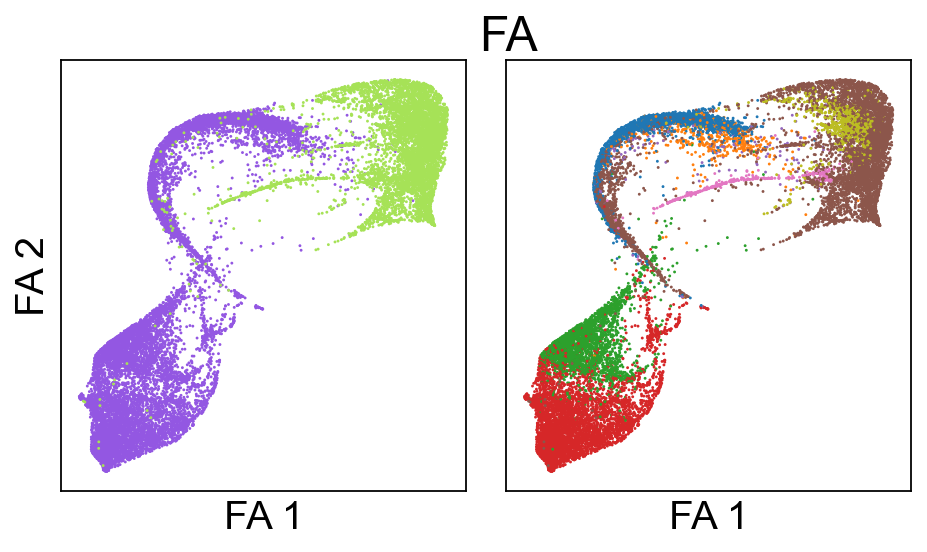

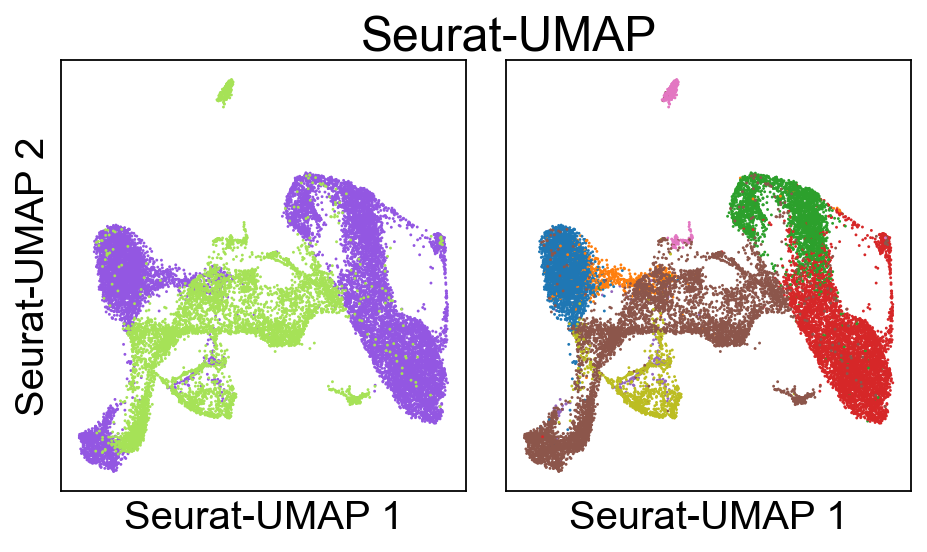

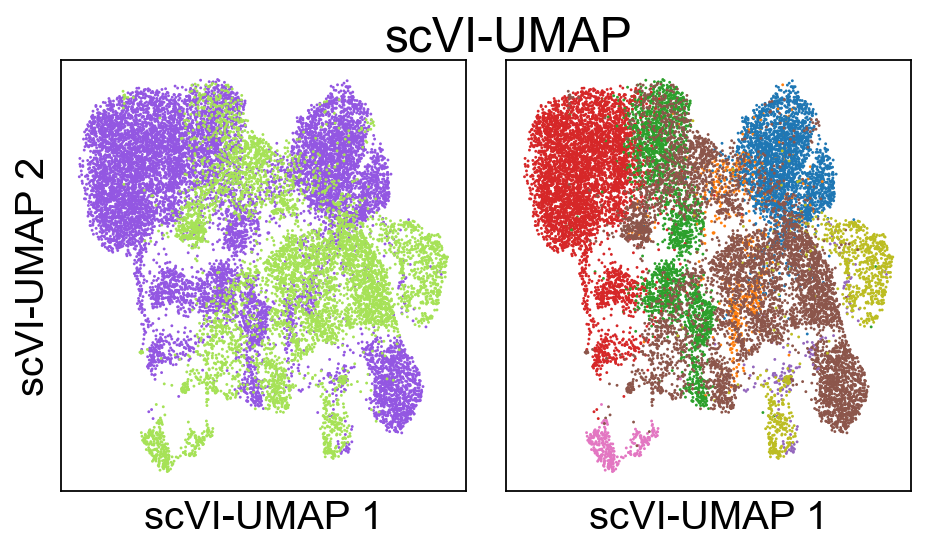

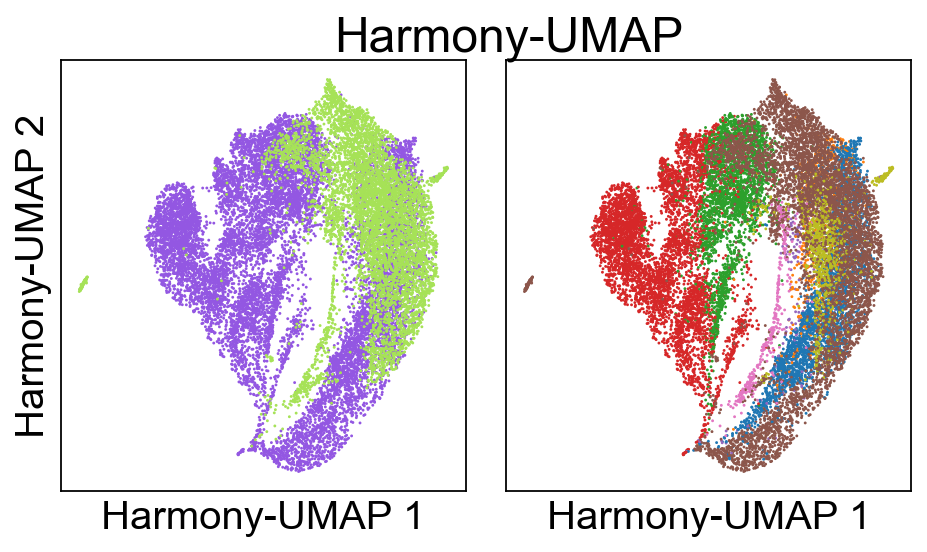

In [98]:
for path, name, attr, ax_label in [
    ("outputs-achille/umap-tsne.h5ad", "umap", "X_umap", "UMAP"),
    ("outputs-achille/umap-tsne.h5ad", "tsne", "X_tsne", "TSNE"),
    ("outputs-achille/forceAtlas2.h5ad", "force_atlas", "X_draw_graph_fa", "FA"),
    ("outputs/seurat.h5ad", "seurat", "X_umap", "Seurat-UMAP"),
    ("outputs-achille/scvi_with_umap.h5ad", "scvi", "X_umap", "scVI-UMAP"),
    ("outputs-achille/harmony_with_umap.h5ad", "harmony", "X_umap", "Harmony-UMAP"),
    #     ("outputs-achille/AML1.decipher.analyzed.h5ad", "decipher_v", "decipher_v", "Decipher v"),
]:
    adata = load_data(path, ref_adata)
    with plt.rc_context({"figure.figsize": [3.5,3.5]}):
        fig = sc.pl.embedding(
            adata,
            basis=attr,
            color=[
                "origin",
                "cell_type_merged",
            ],
            show=False,
            return_fig=True,
            palette=palette_original,
            legend_loc=None,
            wspace=0,
        )
#         fig.tight_layout()
    #     plt.tight_layout()
        fig.axes[0].set_xlabel(ax_label + " 1")
        fig.axes[0].set_ylabel(ax_label + " 2")
        fig.axes[0].set_title(None)
        fig.axes[1].set_xlabel(ax_label + " 1")
        fig.axes[1].set_ylabel(None)
        fig.axes[1].set_title(None)
        fig.suptitle(ax_label)
#         plt.show()
        plt.savefig(f"../figures/extended_figure2/latent.{name}.pdf", bbox_inches="tight")